In [2]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding
import numpy as np
import re

batch_size = 64  # Batch size for training.
epochs = 200  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = './pol.txt'

In [3]:
# Vectorize the data.
texts = []
words = set()

with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    
for line in lines[: min(num_samples, len(lines) - 1)]:
    line = line.lower()
    text, ignore, ignore = line.split('\t') 
    # text = re.sub("'", '', text)
    # text = re.sub(",", ' COMMA', text)
    # text = re.sub(r'[?|!|.|"|0-9]', r'', text)
    
    texts.append(text)
    
    for word in text.split():
        if word not in words:
            words.add(word)

In [4]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(texts)

words_index = tokenizer.word_index
index_2_word = {idx:word for word, idx in words_index.items()}

wids = [[words_index[w] for w in text.text_to_word_sequence(doc)] for doc in texts] #wystapienia ilosc danego slowa

In [5]:
wids[:10]

[[29], [597], [265], [265], [265], [31], [1246], [1246], [1768], [275]]

In [6]:
list(words_index.items())[:10]

[('i', 1),
 ('tom', 2),
 ('you', 3),
 ('is', 4),
 ('a', 5),
 ('it', 6),
 ("i'm", 7),
 ("you're", 8),
 ('the', 9),
 ('he', 10)]

In [7]:
list(index_2_word.items())[:10]

[(1, 'i'),
 (2, 'tom'),
 (3, 'you'),
 (4, 'is'),
 (5, 'a'),
 (6, 'it'),
 (7, "i'm"),
 (8, "you're"),
 (9, 'the'),
 (10, 'he')]

In [8]:
vocab_size = len(words_index) + 1
embed_size = 100
# window_size = 2 # context window size

In [9]:
from keras.preprocessing.sequence import skipgrams

# generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=10) for wid in wids]


In [10]:
skip_grams = [x for x in skip_grams if (x[0] and x[1])]

In [11]:
skip_grams[:10]

[([[17, 6], [6, 17], [6, 54], [17, 2329]], [1, 1, 0, 0]),
 ([[691, 1], [691, 2576], [1, 691], [1, 491]], [1, 0, 1, 0]),
 ([[69, 1173], [69, 1], [1, 69], [1, 394]], [0, 1, 1, 0]),
 ([[1, 69], [1, 569], [69, 1680], [69, 1]], [1, 0, 0, 1]),
 ([[97, 3017], [1, 97], [97, 1], [1, 2471]], [0, 1, 1, 0]),
 ([[1, 1225], [1, 247], [247, 2909], [247, 1]], [0, 1, 0, 1]),
 ([[247, 124], [1, 247], [247, 1], [1, 2312]], [0, 1, 1, 0]),
 ([[247, 1], [1, 47], [247, 598], [1, 247]], [1, 0, 0, 1]),
 ([[692, 55], [692, 438], [55, 2595], [55, 692]], [1, 0, 0, 1]),
 ([[137, 688], [137, 11], [11, 1691], [11, 137]], [0, 1, 0, 1])]

In [12]:
# view sample skip-grams
pairs, labels = skip_grams[2000][0], skip_grams[2000][1]

print(skip_grams[2000])

([[16, 336], [16, 790], [16, 215], [215, 845], [336, 215], [215, 919], [215, 336], [215, 16], [336, 1791], [336, 2779], [336, 16], [16, 2904]], [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0])


In [13]:
for i in range(10):
    print(i)
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          index_2_word[pairs[i][0]], pairs[i][0], 
          index_2_word[pairs[i][1]], pairs[i][1], 
          labels[i]))

0
(my (16), hat (336)) -> 1
1
(my (16), involved (790)) -> 0
2
(my (16), bring (215)) -> 1
3
(bring (215), eight (845)) -> 0
4
(hat (336), bring (215)) -> 1
5
(bring (215), radio (919)) -> 0
6
(bring (215), hat (336)) -> 1
7
(bring (215), my (16)) -> 1
8
(hat (336), cared (1791)) -> 0
9
(hat (336), englishman (2779)) -> 0


In [14]:
from keras.layers import dot
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from tensorflow.keras.models import Sequential

input_target = Input((1,))
input_context = Input((1,))

embedding = Embedding(vocab_size, embed_size, input_length=1, name='embedding')

word_embedding = embedding(input_target)
word_embedding = Reshape((embed_size, 1))(word_embedding)
context_embedding = embedding(input_context)
context_embedding = Reshape((embed_size, 1))(context_embedding)

# now perform the dot product operation  
dot_product = dot([word_embedding, context_embedding], axes=1)
dot_product = Reshape((1,))(dot_product)

# add the sigmoid output layer
output = Dense(1, activation='sigmoid')(dot_product)

model = Model([input_target, input_context], output)
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       302200      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 100, 1)       0           ['embedding[0][0]']          

In [17]:
for epoch in range(1, 6):
    loss = 0
    for i, elem in enumerate(skip_grams):
        pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [pair_first_elem, pair_second_elem]
        Y = labels
        if i % 10000 == 0:
            print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
        loss += model.train_on_batch(X,Y)  

    print('Epoch:', epoch, 'Loss:', loss)

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 2343.3162022978067
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 1820.4479563068599
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 1343.7346689039841
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 1052.3323613011744
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 881.080716128128


In [18]:
import pandas as pd

weights = model.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(index_2_word.values())[0:]).head()

(3021, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
i,-0.178802,0.111654,0.106520,0.277836,0.213204,-0.104765,0.047142,0.199728,0.047123,0.025464,0.121402,-0.055559,0.134294,-0.056478,-0.038109,0.146610,0.054712,0.127994,-0.158956,0.115607,-0.142862,0.070930,0.169178,-0.268649,0.160390,0.139212,0.187315,0.137942,-0.110395,0.188415,-0.195608,0.268865,-0.097087,0.194846,0.159096,-0.248646,0.052364,-0.016864,0.387421,-0.007355,...,0.186798,0.006005,0.224653,-0.268347,0.347429,0.235671,-0.288408,-0.022188,-0.060258,-0.201971,-0.069328,0.045610,-0.195315,-0.200275,0.340794,-0.326551,-0.429872,0.081130,0.133203,-0.250050,0.221872,0.214993,0.125942,0.069598,-0.115241,0.002946,0.027705,-0.086257,-0.007233,0.105273,-0.109777,0.099534,0.178198,-0.314227,0.340026,0.019331,-0.205096,-0.117682,0.239929,0.000984
tom,-0.238897,-0.087140,0.091106,-0.423159,-0.058019,-0.197427,0.145511,0.045729,0.032133,-0.022752,-0.017447,-0.300233,-0.337850,0.105236,0.126084,0.011998,-0.127340,-0.215254,-0.093685,0.103670,-0.246188,0.108407,0.054215,-0.027526,-0.121941,0.070825,-0.116917,-0.107778,-0.075766,-0.108689,0.160608,-0.138355,0.009375,-0.125685,0.176293,0.240439,-0.040056,0.230499,-0.021196,-0.013675,...,0.111693,-0.024210,-0.187373,-0.298842,-0.029480,0.187268,-0.102734,0.172897,-0.268430,-0.106082,0.045032,0.040562,0.264691,0.019808,0.362266,-0.109291,0.150976,-0.016573,0.462731,0.191842,0.154632,0.089450,-0.311279,0.031161,0.040561,-0.175822,0.083957,0.117192,-0.158933,-0.108770,-0.181171,-0.096609,-0.202999,0.095698,-0.070634,0.028971,-0.209851,-0.103718,0.191750,-0.199315
you,0.264452,0.174830,0.011075,0.174748,-0.236268,0.388704,-0.190777,-0.377192,-0.211020,0.106797,-0.201672,-0.023250,-0.308503,0.315603,0.354186,-0.215647,0.175256,0.140169,-0.198202,0.472318,-0.237438,0.357516,-0.160254,0.173757,-0.427077,0.168096,-0.202835,0.207366,0.085434,-0.372555,0.225709,0.381847,0.316822,0.443448,-0.243818,-0.278579,-0.541123,0.508090,-0.254748,-0.117200,...,-0.169539,0.163602,0.147722,-0.208496,0.012000,-0.214376,-0.365987,0.237469,0.261638,-0.364859,0.485789,0.259807,-0.461582,-0.017783,0.113528,-0.235221,0.224001,-0.052849,-0.037192,-0.020206,-0.318853,0.245758,0.266622,0.125570,0.353303,-0.102631,0.539332,0.138085,-0.297514,0.303677,0.371874,-0.179386,0.070956,-0.167329,0.130919,-0.114383,-0.022696,-0.203391,0.052693,-0.184156
is,-0.062554,0.337930,-0.237022,-0.077260,0.260405,-0.368854,0.133154,-0.015380,-0.053636,-0.189602,0.269630,-0.093742,0.331690,-0.039867,0.008861,0.050734,-0.158147,0.244681,-0.438097,0.415278,-0.047495,-0.171376,-0.062169,-0.053217,0.301258,0.112994,0.143693,0.076641,-0.496359,-0.133282,0.071834,0.106235,0.313425,0.157074,-0.350003,0.320990,-0.115823,-0.164248,-0.066872,0.203456,...,0.124481,0.098717,0.190127,0.301930,0.146727,-0.388901,-0.194683,0.082581,-0.263544,0.236590,-0.200479,-0.405523,0.391617,-0.013335,-0.113848,0.305902,0.129128,-0.398157,0.225589,-0.195298,-0.381962,0.244974,-0.127331,0.200733,-0.077130,0.253531,-0.180323,0.114682,-0.279966,0.019168,0.304127,0.292768,-0.054235,-0.261211,-0.101676,0.329480,0.534074,0.072005,0.443025,-0.062710
a,-0.084648,-0.264575,0.101549,-0.149238,0.241332,-0.208796,-0.135501,-0.124732,0.091032,0.026638,-0.243773,0.195645,0.183358,-0.105374,-0.323811,0.210188,0.111082,0.293231,0.134480,-0.383196,-0.047690,0.102220,-0.331289,0.158655,-0.519273,0.445040,0.200311,-0.164243,-0.220055,-0.213156,0.062943,0.402355,-0.257555,0.165876,0.257649,0.249921,0.196655,0.517131,-0.494796,-0.450324,...,-0.222988,0.298448,0.156247,-0.338909,0.091092,0.055769,-0.082881,0.048303,0.190117,-0.073947,0.048316,-0.353438,0.185521,0.013612,-0.329182,0.406499,-0.548464,-0.208451,-0.351327,-0.131013,-0.101890,-0.240868,-0.269934,-0.082632,-0.282533,0.438795,0.003977,-0.117529,0.389371,-0.023860,-0.208081,-0.049023,0.087463,-

In [19]:
from sklearn.metrics.pairwise import euclidean_distances

# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [index_2_word[idx] for idx in distance_matrix[words_index[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['tom', 'you', 'wait', 'hang', 'yet', 'a', 'the','coat']}

similar_words

(3021, 3021)


{'a': ['arrest', 'suicide', 'coming', 'last', 'tent'],
 'coat': ['immune', 'snowed', 'hamlet', 'officer', 'way'],
 'hang': ['mahjong', 'gorgeous', 'grapes', 'human', 'put'],
 'the': ['italy', 'pilots', 'ignoring', 'unfortunate', 'shocked'],
 'tom': ['robbed', 'sell', 'european', 'body', 'higher'],
 'wait': ['hang', 'threw', 'relief', 'movies', 'waited'],
 'yet': ['deleted', 'alarmed', 'heaven', 'freezing', 'broom'],
 'you': ['responsibly', 'raining', 'few', 'ridiculous', 'picked']}

Total words: 48 	Word Embedding shapes: (48, 100)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


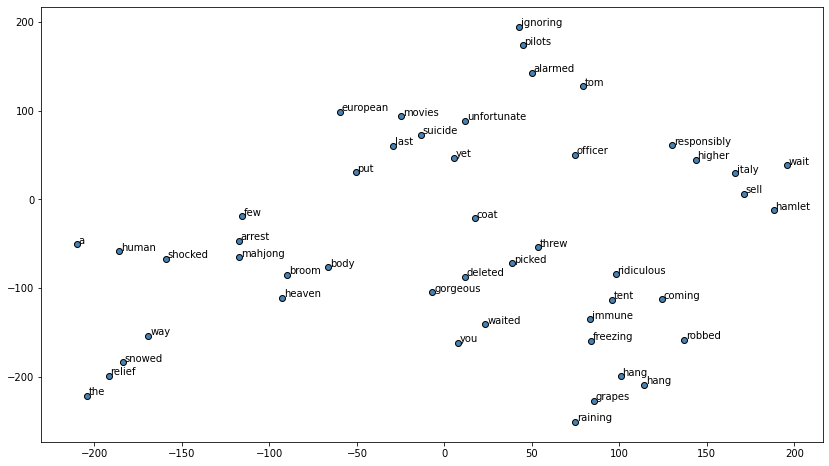

In [20]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [words_index[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')